## CNN training trial 11

- Pneumonia vs No Pneumonia
- Using pretrained CNN VGG16, based on this [bibliography](https://doi.org/10.1016/j.gltp.2021.08.027) that show slighty better perfomance than RESNET50: 
- Retraining last block of VGG16 convolution layers and added a new Conv2D layer in order to make GradCAM activation map
- Adjustment for unbalanced dataset
- Auto learning rate. 
- With image augmentation
- Image cropping for keeping only lung tissue
- Data leakeage fixed

### Library importing

In [14]:
## Basic libraries
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, Cropping2D, CenterCrop, Resizing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score,precision_recall_curve, f1_score, precision_score, recall_score
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.image import resize, grayscale_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


### Settings for the model training

In [15]:
pretrained = 'vgg16'
seed = 42
dense_n = [1024,512,256]
dropout = [0.4,0.3,0]
batch_n = 32
epochs = 200
save_all_epochs = True
kernel_size = (3,3)
learning_rate = 0.001
version = 'v11'
patience = 10
start_patience = 70
img_size = (224, 224)
filename_prefix = 'xray_udacity'
column_images = 'path'
path_images = './bigdata/images/all/'
path_csv = './data/'
file_csv = path_csv + 'Data_Entry_2017.csv'
path_for_generator = None
column_images = 'path'
columns = ['imgindex', 'labels', 'followup', 'id', 'age', 'sex','position', 'width', 'height', 'x','y', 'wrong']
feature_to_classify = 'Pneumonia'
layer_vgg16_of_interest = 'block4_pool'

## Data loading and preprocessing

In [16]:
## Load NIH data
df = pd.read_csv(file_csv, index_col=0,header=0,names=columns).drop('wrong', axis=1)

all_image_paths = {os.path.basename(x): x for x in 
                glob(os.path.join(path_images, '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', df.shape[0])
df['path'] = df['imgindex'].map(all_image_paths.get)

all_labels = np.unique(list(chain(*df['labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['labels'].map(lambda finding: 1.0 if c_label in finding else 0)

df[feature_to_classify] = np.where(df[feature_to_classify] == 1, 'Yes', 'No')

Scans found: 112120 , Total Headers 112120


In [17]:
df.head()

imgindex                  labels  followup  id  age sex position  \
0  00000001_000.png            Cardiomegaly         0   1   58   M       PA   
1  00000001_001.png  Cardiomegaly|Emphysema         1   1   58   M       PA   
2  00000001_002.png   Cardiomegaly|Effusion         2   1   58   M       PA   
3  00000002_000.png              No Finding         0   2   81   M       PA   
4  00000003_000.png                  Hernia         0   3   81   F       PA   

   width  height      x  ...  Emphysema Fibrosis  Hernia  Infiltration  Mass  \
0   2682    2749  0.143  ...        0.0      0.0     0.0           0.0   0.0   
1   2894    2729  0.143  ...        1.0      0.0     0.0           0.0   0.0   
2   2500    2048  0.168  ...        0.0      0.0     0.0           0.0   0.0   
3   2500    2048  0.171  ...        0.0      0.0     0.0           0.0   0.0   
4   2582    2991  0.143  ...        0.0      0.0     1.0           0.0   0.0   

   No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
0         0.0     0.0                 0.0         No           0.0  
1         0.0     0.0                 0.0         No           0.0  
2         0.0     0.0                 0.0         No           0.0  
3         1.0     0.0                 0.0         No           0.0  
4         0.0     0.0                 0.0         No           0.0  

[5 rows x 27 columns]

In [18]:
df.Pneumonia.value_counts()

No     110689
Yes      1431
Name: Pneumonia, dtype: int64

In [19]:
mask_age = df['age'] > 100
print('Number of wrong age: {:.0f}'.format(df.loc[mask_age, 'age'].shape[0]))
mask_age = df['age'] > 100
#print(df.loc[mask_age, 'age'].sort_values(ascending=False).head(10))
mask_age = df['age'] < 100
df = df.loc[mask_age, :]

Number of wrong age: 16


### Train-test split

Taking in account this considerations:
- Train database = 50% non pneumonia vs 50% pneumonia. 
- Test database = Should have the real frequency of pneumonia expected in the clinical setting. ~ 20%. 
- No data leakeage
- Balance datasets for every feature

In [20]:
def check_for_leakage(train, val, feature):
    count =0
    ### We put all rows from val set that are in train set in a new dataframe
    empty_df = pd.DataFrame(columns=train.columns.tolist())

    ### We iterate over all ID in train set checking if they are in val set
    for i in train['id'].values:
        if i in val['id'].values:
            ### If they are, we put them in the new dataframe and delete them from val set
            empty_df = pd.concat([empty_df, val[val['id'] == i]], axis=0)
            val.drop(val[val['id'] == i].index, inplace=True)
            count +=1
    ### We concatenate the new dataframe with the train set - we don't delete data
    train = pd.concat([train, empty_df], axis=0)
    print('Total of leakage deleted from test set: ',count)
    return train, val

def make_split():
    #### Get all pneumonia cases
    df_pneumonia = df[df[feature_to_classify] == 'Yes']
    ### Get all ID from Pneumonia cases for avoiding data leakage
    pneumonia_id = df_pneumonia['id'].unique()

    #### Get all non-pneumonia cases
    df_non_pneumonia = df[df[feature_to_classify] == 'No']
    ### Get all ID from non-Pneumonia cases for avoiding data leakage
    non_pneumonia_id = df_non_pneumonia['id'].unique()

    #### We check of ID coincidence between pneumonia and non-pneumonia cases
    print('Coincidence between pneumonia and non-pneumonia IDs:', np.intersect1d(pneumonia_id, non_pneumonia_id).shape[0])

    ### Train and test split for Pneumonia cases
    ### We put different for test_size because then we will fix for data leakeage and balance the data
    df_pneumonia_train, df_pneumonia_test = train_test_split(df_pneumonia, test_size=0.4, random_state=seed, stratify=df_pneumonia[[feature_to_classify, 'sex', 'position']])

    ### Train and test split for non-Pneumonia cases
    ### We put different for test_size because then we will fix for data leakeage and balance the data
    df_non_pneumonia_train, df_non_pneumonia_test = train_test_split(df_non_pneumonia, test_size=0.6, random_state=seed, stratify=df_non_pneumonia[[feature_to_classify, 'sex', 'position']])

    df_pneumonia_train, df_pneumonia_test = check_for_leakage(df_pneumonia_train, df_pneumonia_test, feature_to_classify)
    df_non_pneumonia_train, df_non_pneumonia_test = check_for_leakage(df_non_pneumonia_train, df_non_pneumonia_test, feature_to_classify)

    print('Test set {} proportion: {:.2f}'.format(feature_to_classify,df_pneumonia_test.shape[0]/(df_pneumonia_train.shape[0]+df_pneumonia_test.shape[0])))
    print('Test set non-{} proportion: {:.2f}'.format(feature_to_classify,df_non_pneumonia_test.shape[0]/(df_non_pneumonia_train.shape[0]+df_non_pneumonia_test.shape[0])))

        #### Now we balance the data
    df_final_train = df_non_pneumonia_train.sample(n=df_pneumonia_train.shape[0], random_state=seed)
    df_final_train = pd.concat([df_final_train, df_pneumonia_train], axis=0)

    df_final_test = df_non_pneumonia_test.sample(n=df_pneumonia_test.shape[0]*4, random_state=seed)
    df_final_test = pd.concat([df_final_test, df_pneumonia_test], axis=0)

    ## Print the proportion of pneumonia cases in train and test set
    print('Final train set {} proportion: {:.2f}'.format(feature_to_classify,df_final_train[df_final_train[feature_to_classify] == 'Yes'].shape[0]/df_final_train.shape[0]))
    print('Final test set {} proportion: {:.2f}'.format(feature_to_classify,df_final_test[df_final_test[feature_to_classify] == 'Yes'].shape[0]/df_final_test.shape[0]))
    print('Final train set shape: ', df_final_train.shape)
    print('Final test set shape: ', df_final_test.shape)
    
    return df_final_train, df_final_test

In [21]:
train_data, val_data = make_split()

Coincidence between pneumonia and non-pneumonia IDs: 928
Total of leakage deleted from test set:  137
Total of leakage deleted from test set:  10214
Test set Pneumonia proportion: 0.25
Test set non-Pneumonia proportion: 0.15
Final train set Pneumonia proportion: 0.50
Final test set Pneumonia proportion: 0.20
Final train set shape:  (2138, 27)
Final test set shape:  (1805, 27)


#### Checking visually that train set represent overall dataset

In [22]:
import warnings
warnings.filterwarnings("ignore")

def check_dataset_overall(df, df2):
       ### Libraries importing
       import matplotlib.pyplot as plt
       import seaborn as sns
       import squarify

       #### Plot comparing Age distribution by sex for train,test
       fig, ax = plt.subplots(2, 2, figsize=(7, 7))
       ## Train set
       plt.suptitle(f'Age distribution by sex')
       sns.histplot(df.loc[df['sex'] == 'F', "age"],
              kde=True, color="olive", label = 'F', bins=20, ax=ax[0,0])
       sns.histplot(df.loc[df['sex'] == 'M', "age"],
              kde=True, color="gold", label = 'M', bins=20, ax=ax[1,0])
       ax[0,0].legend(prop={'size': 12})
       ax[0,0].title.set_text('Train set')
       ax[1,0].legend(prop={'size': 12})
       ax[1,0].title.set_text('Train set')

       ## Test set
       sns.histplot(df2.loc[df2['sex'] == 'F', "age"],
       kde=True, color="olive", label = 'F', bins=20, ax=ax[0,1])
       sns.histplot(df2.loc[df2['sex'] == 'M', "age"],
              kde=True, color="gold", label = 'M', bins=20, ax=ax[1,1])
       ax[0,1].legend(prop={'size': 12})
       ax[0,1].title.set_text('Test set')
       ax[1,1].legend(prop={'size': 12})
       ax[1,1].title.set_text('Test set')
       plt.tight_layout()
       plt.show()

       #### Plot comparing Followup distribution by sex for train,test
       fig, ax = plt.subplots(2, 2, figsize=(7, 7))
       plt.suptitle(f'Follow-up distribution by sex')
       ## Train set
       sns.histplot(df.loc[df['sex'] == 'F', "followup"],
              kde=True, color="olive", label = 'F', bins=20, ax=ax[0,0])
       sns.histplot(df.loc[df['sex'] == 'M', "followup"],
              kde=True, color="gold", label = 'M', bins=20, ax=ax[1,0])
       ax[0,0].legend(prop={'size': 12})
       ax[0,0].title.set_text('Train set')
       ax[1,0].legend(prop={'size': 12})
       ax[1,0].title.set_text('Train set')

       ## Test set
       sns.histplot(df2.loc[df2['sex'] == 'F', "followup"],
              kde=True, color="olive", label = 'F', bins=20, ax=ax[0,1])
       sns.histplot(df2.loc[df2['sex'] == 'M', "followup"],
              kde=True, color="gold", label = 'M', bins=20, ax=ax[1,1])
       ax[0,1].legend(prop={'size': 12})
       ax[0,1].title.set_text('Test set')
       ax[1,1].legend(prop={'size': 12})
       ax[1,1].title.set_text('Test set')
       plt.tight_layout()
       plt.show()

       #### Plot comparing Position by Sex for train,test
       fig, ax = plt.subplots(1, 2, figsize=(7, 7))
       plt.suptitle('Position by Sex')
       ## Train set
       df.groupby('position')['sex'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10, 5), color=['gold', 'olive'], ax=ax[0])
       ax[0].legend(prop={'size': 12}, loc='upper left')
       ax[0].title.set_text('Train set')

       ## Test set
       df2.groupby('position')['sex'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10, 5), color=['gold', 'olive'], ax=ax[1])
       ax[1].legend(prop={'size': 12}, loc='upper left')
       ax[1].title.set_text('Test set')
       plt.xticks(rotation=0)
       plt.xlabel('Position')
       plt.ylabel('Count')
       plt.tight_layout()
       plt.show()

       #### Plot comparing position by age distribution for train,test
       fig, ax = plt.subplots(2, 2, figsize=(7, 7))
       plt.suptitle(f'Age distribution by position')
       ## Train set
       sns.histplot(df.loc[df['position'] == 'AP', "age"],
              kde=True, color="olive", label = 'Antero-posteiror', bins=20, ax=ax[0,0])
       sns.histplot(df.loc[df['position'] == 'PA', "age"],
              kde=True, color="gold", label = 'Postero-anterior', bins=20, ax=ax[1,0])
       ax[0,0].legend(prop={'size': 12})
       ax[1,0].legend(prop={'size': 12})

       ## Test set
       sns.histplot(df2.loc[df2['position'] == 'AP', "age"],
              kde=True, color="olive", label = 'Antero-posteiror', bins=20, ax=ax[0,1])
       sns.histplot(df2.loc[df2['position'] == 'PA', "age"],
              kde=True, color="gold", label = 'Postero-anterior', bins=20, ax=ax[1,1])
       ax[0,1].legend(prop={'size': 12})
       ax[1,1].legend(prop={'size': 12})
       plt.tight_layout()
       plt.show()

       #### Plot comparing multilabel distribution by sex for train,test
       fig, ax = plt.subplots(2, 1, figsize=(7, 8))

       ### Train set
       subset = df[['sex', 'labels']]
       subset.index = subset.labels
       subset = subset.drop('labels', axis=1)
       list_main_labels = subset.groupby(level=0).value_counts().unstack().fillna(0).sort_values(by='M', ascending=False)[1:15]
       labels1 = list_main_labels.index.tolist()
       list_main_labels.plot(kind='bar', stacked = True, color=['gold', 'olive'], title='Train: Multilabel distribution by sex', ax=ax[0])
       ax[0].set_xticklabels(labels1, fontdict = {'fontsize': 8}, rotation=45, ha='right')

       ### Test set
       subset2 = df2[['sex', 'labels']]
       subset2.index = subset2.labels
       subset2 = subset2.drop('labels', axis=1)
       list_main_labels2 = subset2.groupby(level=0).value_counts().unstack().fillna(0).sort_values(by='M', ascending=False)[1:15]
       labels2 = list_main_labels2.index.tolist()
       list_main_labels2.plot(kind='bar', stacked = True, color=['gold', 'olive'], title='Test: Multilabel distribution by sex', ax=ax[1])
       ax[1].set_xticklabels(labels2,fontdict = {'fontsize': 8},rotation=45, ha='right')
       plt.tight_layout()
       plt.show()


       #### Plot comparing single label distribution by sex for train,test
       fig, ax = plt.subplots(2, 1, figsize=(7, 7))
       ## Train set
       columns_to_drop = ['imgindex', 'labels', 'followup','id', 'age', 'position',
              'width', 'height', 'x', 'y',]
       subset_2 = df.drop(columns_to_drop, axis = 1)
       subset_2.index = subset_2['sex']
       subset_2.drop('sex', axis=1, inplace=True)

       list_main_labels_2 = subset_2.groupby(level=0).sum().T.sort_values(by='F', ascending=False)[1:15]
       labels3 = list_main_labels_2.index.tolist()
       list_main_labels_2.plot(kind='bar', stacked=True, color=['gold', 'olive'], title='Train: Sex distribution by single pathologies', ax=ax[0])
       ax[0].set_xticklabels(labels3,fontdict = {'fontsize': 8},rotation=45, ha='right')

       ## Test set
       subset_22 = df2.drop(columns_to_drop, axis = 1)
       subset_22.index = subset_22['sex']
       subset_22.drop('sex', axis=1, inplace=True)

       list_main_labels_22 = subset_22.groupby(level=0).sum().T.sort_values(by='F', ascending=False)[1:15]
       labels4 = list_main_labels_22.index.tolist()

       list_main_labels_22.plot(kind='bar', stacked=True, color=['gold', 'olive'], title='Test: Sex distribution by single pathologies', ax=ax[1])
       ax[1].set_xticklabels(labels4,fontdict = {'fontsize': 8},rotation=45, ha='right')
       plt.tight_layout()
       plt.show()



       ### Squarify plot comparing mean age by pathology for train, test
       fig, ax = plt.subplots(2, 1, figsize=(7,7))
       pathologies = ['Atelectasis', 'Cardiomegaly',
              'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
              'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
              feature_to_classify, 'Pneumothorax']

       age = ['age']

       ## Train set
       subset_3 = df[pathologies + age]

       newdf = pd.DataFrame(columns=['Pathology', 'Mean Age'])
       for i in pathologies:
              age = subset_3.groupby(i)['age'].mean()[1]
              df_temp = pd.DataFrame({'Pathology': i, 'Mean Age': age}, index=[0])
              newdf = pd.concat([newdf, df_temp], ignore_index=True)

       newdf = newdf.sort_values(by='Mean Age', ascending=False)
       newdf = newdf.reset_index(drop=True)
       squarify.plot(sizes=newdf['Mean Age'], label=newdf['Pathology'], alpha=.8 , color=sns.color_palette("Set2", 10), value=newdf['Mean Age'].round(1), ax=ax[0])
       ax[0].set_title('Mean age by pathology for train set')
       ax[0].axis('off')

       ## Test set
       subset_32 = df2[pathologies + ['age']]

       newdf2 = pd.DataFrame(columns=['Pathology', 'Mean Age'])
       for i in pathologies:
              age2 = subset_32.groupby(i)['age'].mean()[1]
              df_temp2 = pd.DataFrame({'Pathology': i, 'Mean Age': age2}, index=[0])
              newdf2 = pd.concat([newdf2, df_temp2], ignore_index=True)

       newdf2 = newdf2.sort_values(by='Mean Age', ascending=False)
       newdf2 = newdf2.reset_index(drop=True)
       squarify.plot(sizes=newdf2['Mean Age'], label=newdf2['Pathology'], alpha=.8 , color=sns.color_palette("Set2", 10), value=newdf2['Mean Age'].round(1), ax=ax[1])
       ax[1].set_title('Mean age by pathology for test set')

       ax[1].axis('off')
       plt.tight_layout()
       plt.show()


       ## Plot comparing number of pathologies by X-Ray for train, test
       fig, axarr = plt.subplots(2, 2, figsize=(7, 7))

       ## Train set
       df.loc[df['No Finding']==0, pathologies].sum(axis=1).plot.hist(logy=True, ax=axarr[0,0], title='Train: pathologies by X-Ray', color=['gold', 'olive'])
       axarr[0,0].set_xlabel('Number of diseases')

       df.loc[(df['No Finding']==0) & (df[feature_to_classify]=='Yes'),pathologies].sum(axis=1).plot.hist(logy=True, ax=axarr[1,0], title='Train: Pneumonia with other', color=['gold', 'olive'])
       axarr[1,0].set_xlabel('Number of diseases')


       ## Test set
       df2.loc[df2['No Finding']==0, pathologies].sum(axis=1).plot.hist(logy=True, ax=axarr[0,1], title='Test: pathologies by X-Ray', color=['gold', 'olive'])
       axarr[0,1].set_xlabel('Number of diseases')

       df2.loc[(df2['No Finding']==0) & (df2[feature_to_classify]=='Yes'),pathologies].sum(axis=1).plot.hist(logy=True, ax=axarr[1,1], title='Test: Pneumonia with other', color=['gold', 'olive'])
       axarr[1,1].set_xlabel('Number of diseases')
       plt.tight_layout()
       plt.show()

def check_dataset_pneumonia(df, df2):

       ### Libraries
       import matplotlib.pyplot as plt
       import seaborn as sns
       import squarify

       #### Pneumonia distribution by Sex
       fig, ax = plt.subplots(2, 2, figsize=(7, 7))

       ## Train set
       mask_no = df[feature_to_classify] == 'No'
       mask_yes = df[feature_to_classify] == 'Yes'
       df[mask_no].groupby(feature_to_classify)['sex'].value_counts().unstack().plot(kind='bar', stacked=True, color=['gold', 'olive'], title='Train: Not Pneumonia', ax=ax[0,0])
       plt.legend(prop={'size': 12}, loc='upper left')
       plt.xticks(rotation=0)
       plt.suptitle('Pneumonia distribution by Sex')
       ax[0,0].set_xlabel('')
       ax[0,0].set_xticks([])

       df[mask_yes].groupby(feature_to_classify)['sex'].value_counts().unstack().plot(kind='bar', stacked=True, color=['gold', 'olive'], title='Train: Yes Pneumonia', ax=ax[1,0])
       plt.legend(prop={'size': 12}, loc='upper left', title = 'sex')
       plt.xticks(rotation=0)
       ax[1,0].set_xlabel('')
       ax[1,0].set_xticks([])


       ## Test set
       mask2_no = df2[feature_to_classify] == 'No'
       mask2_yes = df2[feature_to_classify] == 'Yes'
       df2[mask2_no].groupby(feature_to_classify)['sex'].value_counts().unstack().plot(kind='bar', stacked=True,  color=['gold', 'olive'], title='Test: Not Pneumonia', ax=ax[0,1])
       plt.legend(prop={'size': 12}, loc='upper left')
       plt.xticks(rotation=0)
       ax[0,1].set_xlabel('')
       ax[0,1].set_xticks([])

       df2[mask2_yes].groupby(feature_to_classify)['sex'].value_counts().unstack().plot(kind='bar', stacked=True, color=['gold', 'olive'], title='Test: Yes Pneumonia', ax=ax[1,1])
       plt.legend(prop={'size': 12}, loc='upper left', title = 'sex')
       plt.xticks(rotation=0)
       ax[1,1].set_xlabel('')
       ax[1,1].set_xticks([])
       plt.tight_layout()
       plt.show()


       ### Age distribution by Pneumonia
       fig, ax = plt.subplots(2, 2, figsize=(7, 7))
       plt.suptitle(f'Age distribution by Pneumonia')

       ## Train set
       sns.histplot(df.loc[df[feature_to_classify] == 'Yes', "age"],
              kde=True, color="olive", label = 'Yes Pneumonia', bins=20, ax=ax[0,0])
       sns.histplot(df.loc[df[feature_to_classify] == 'No', "age"],
              kde=True, color="gold", label = 'No Pneumonia', bins=20, ax=ax[1,0])
       ax[0,0].legend(prop={'size': 12})
       ax[1,0].legend(prop={'size': 12})
       ax[0,0].set_title('Train set')
       ax[1,0].set_title('Train set')

       ## Test set
       sns.histplot(df2.loc[df2[feature_to_classify] == 'Yes', "age"],
       kde=True, color="olive", label = 'Yes Pneumonia', bins=20, ax=ax[0,1])
       sns.histplot(df2.loc[df2[feature_to_classify] == 'No', "age"],
              kde=True, color="gold", label = 'No Pneumonia', bins=20, ax=ax[1,1])
       ax[0,1].legend(prop={'size': 12})
       ax[1,1].legend(prop={'size': 12})
       ax[0,1].set_title('Test set')
       ax[1,1].set_title('Test set')

       plt.tight_layout()
       plt.show()



       ### Follow-up distribution by Pneumonia
       fig, ax = plt.subplots(2, 2, figsize=(7, 7))
       plt.suptitle(f'Follow-up distribution by Pneumonia')

       ## Train set
       sns.histplot(df.loc[df[feature_to_classify] == 'Yes', "followup"],
              kde=True, color="olive", label = 'Yes Pneumonia', bins=20, ax=ax[0,0])
       sns.histplot(df.loc[df[feature_to_classify] == 'No', "followup"],
              kde=True, color="gold", label = 'No Pneumonia', bins=20, ax=ax[1,0])
       ax[0,0].legend(prop={'size': 12})
       ax[1,0].legend(prop={'size': 12})
       ax[0,0].set_title('Train set')
       ax[1,0].set_title('Train set')


       ## Test set
       sns.histplot(df.loc[df[feature_to_classify] == 'Yes', "followup"],
       kde=True, color="olive", label = 'Yes Pneumonia', bins=20, ax=ax[0,1])
       sns.histplot(df.loc[df[feature_to_classify] == 'No', "followup"],
              kde=True, color="gold", label = 'No Pneumonia', bins=20, ax=ax[1,1])
       ax[0,1].legend(prop={'size': 12})
       ax[1,1].legend(prop={'size': 12})
       ax[0,1].set_title('Test set')
       ax[1,1].set_title('Test set')

       plt.tight_layout()
       plt.show()


       ### Pneumonia distribution by Position
       fig, ax = plt.subplots(2, 2, figsize=(7, 7))

       ## Train set
       mask_no = df[feature_to_classify] == 'Yes'
       mask_yes = df[feature_to_classify] == 'No'
       df[mask_no].groupby(feature_to_classify)['position'].value_counts().unstack().plot(kind='bar', stacked=True, color=['gold', 'olive'], ax=ax[0,0])
       ax[0,0].set_xlabel('')
       ax[0,0].set_xticks([])
       ax[0,0].set_title('Train set (Not Pneumonia)')
       


       plt.suptitle('Pneumonia distribution by Position')
       df[mask_yes].groupby(feature_to_classify)['position'].value_counts().unstack().plot(kind='bar', stacked=True,color=['gold', 'olive'], ax=ax[1,0])
       ax[1,0].set_xticks([])
       ax[1,0].set_xlabel('')
       ax[1,0].set_title('Train set (Yes Pneumonia)')


       ## Test set
       mask2_no = df2[feature_to_classify] == 'Yes'
       mask2_yes = df2[feature_to_classify] == 'No'
       df2[mask2_no].groupby(feature_to_classify)['position'].value_counts().unstack().plot(kind='bar', stacked=True, color=['gold', 'olive'], ax=ax[0,1])
       ax[0,1].set_xlabel('')
       ax[0,1].set_xticks([])
       ax[0,1].set_title(f'Test set (Not {feature_to_classify})')

       df2[mask2_yes].groupby(feature_to_classify)['position'].value_counts().unstack().plot(kind='bar', stacked=True,  color=['gold', 'olive'], ax=ax[1,1])
       ax[1,1].set_xticks([])
       ax[1,1].set_xlabel('')
       ax[1,1].set_title(f'Test set (Yes {feature_to_classify})')

       plt.tight_layout()
       plt.show()



       ### Sex distribution by Position for Pneumonia subset
       fig, ax = plt.subplots(2,1, figsize=(7, 7))
       ## Train set
       mask_yes = df[feature_to_classify] == 'Yes'
       df[mask_yes].groupby('sex')['position'].value_counts().unstack().plot(kind='bar', stacked=True,  color=['gold', 'olive'], ax=ax[0])
       plt.suptitle(f'Train: Sex distribution by Position for {feature_to_classify} subset')
       plt.xticks(rotation=0)

       ## Test set
       mask2_yes = df2[feature_to_classify] == 'Yes'
       df2[mask2_yes].groupby('sex')['position'].value_counts().unstack().plot(kind='bar', stacked=True,  color=['gold', 'olive'], ax=ax[1])
       plt.suptitle(f'Test: Sex distribution by Position for {feature_to_classify} subset')
       plt.xticks(rotation=0)

       plt.tight_layout()
       plt.show()


       ## Correlation matrix
       fig, ax = plt.subplots(2,1, figsize=(7, 7))
       pathologies = ['Atelectasis', 'Cardiomegaly',
              'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
              'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
              feature_to_classify, 'Pneumothorax']
       ## Train set
       sns.heatmap(df[pathologies].corr(method='spearman'), annot=True, fmt='.1g', cmap='coolwarm', ax = ax[0])
       ax[0].set_title('Train set')

       ## Test set
       sns.heatmap(df2[pathologies].corr(method='spearman'), annot=True, fmt='.1g', cmap='coolwarm', ax = ax[1])
       ax[1].set_title('Test set')

       plt.tight_layout()
       plt.show()

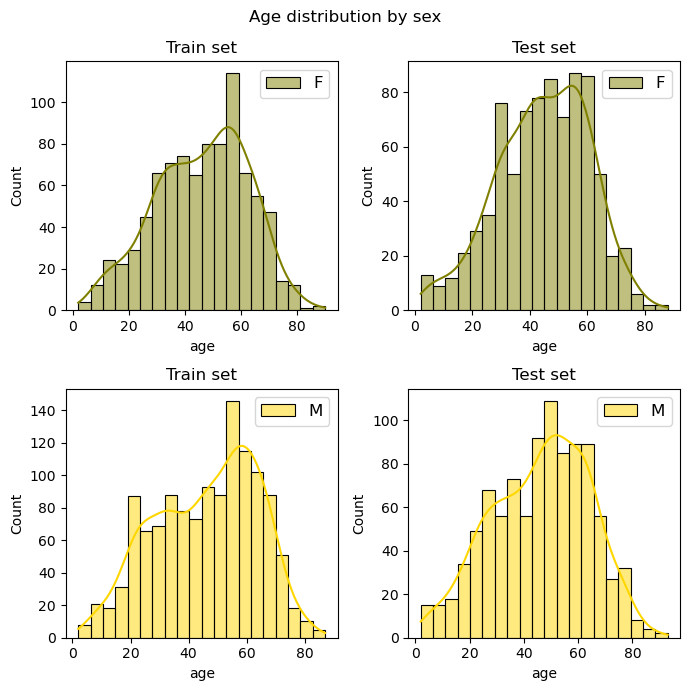

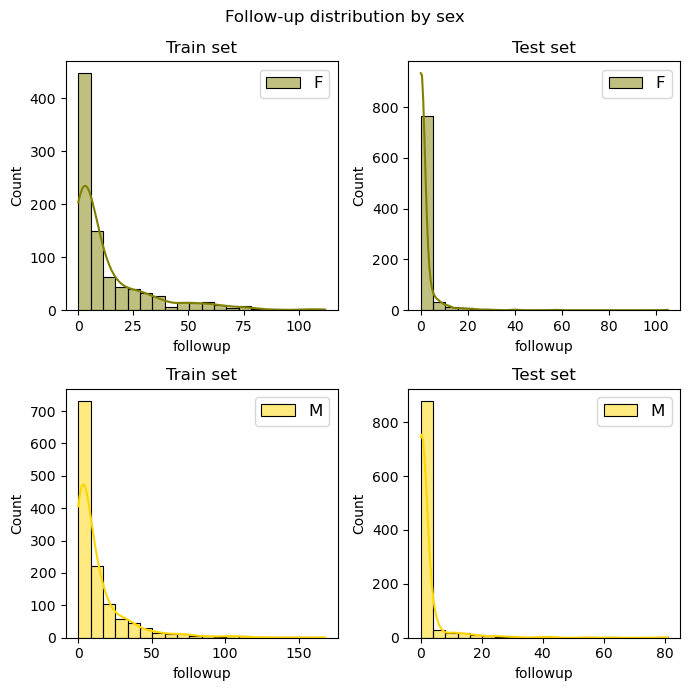

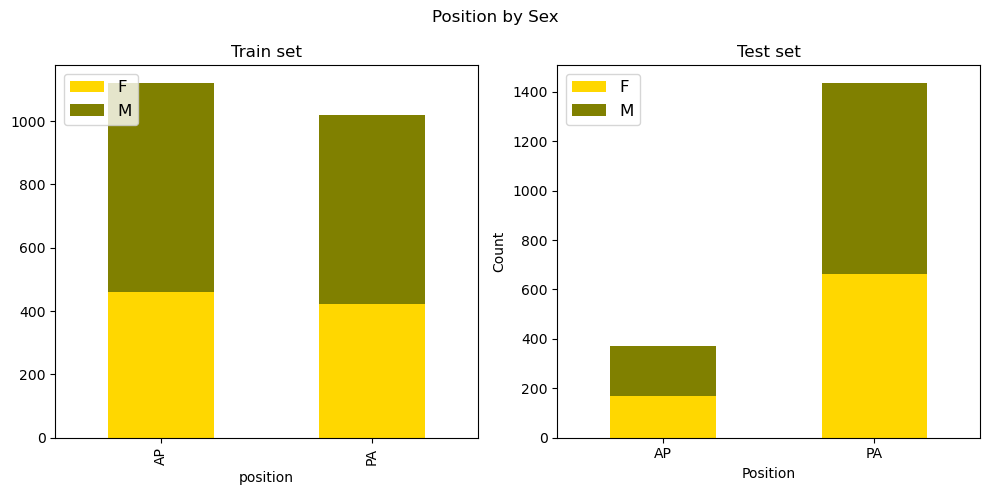

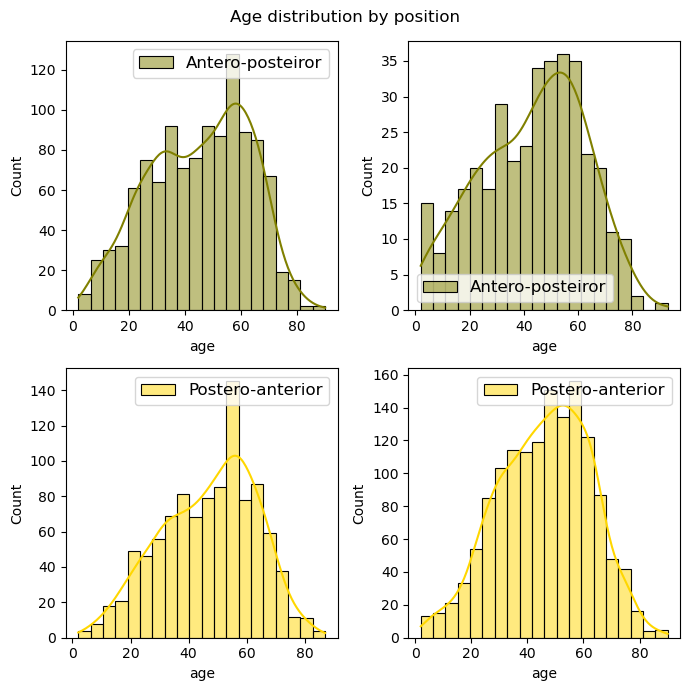

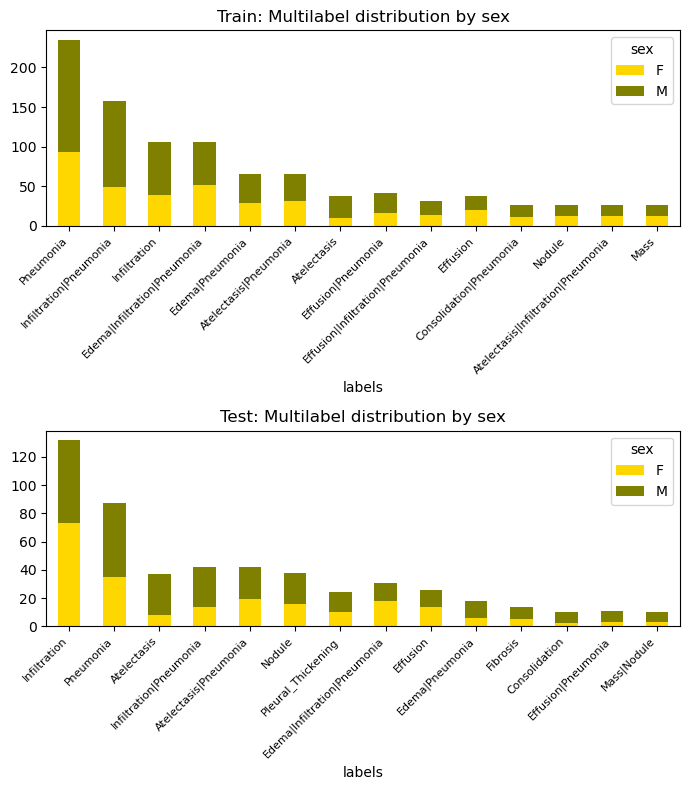

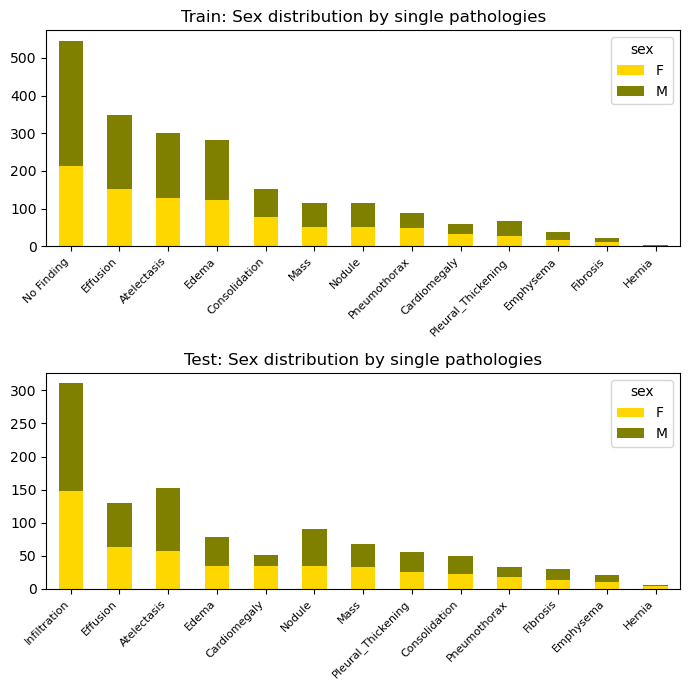

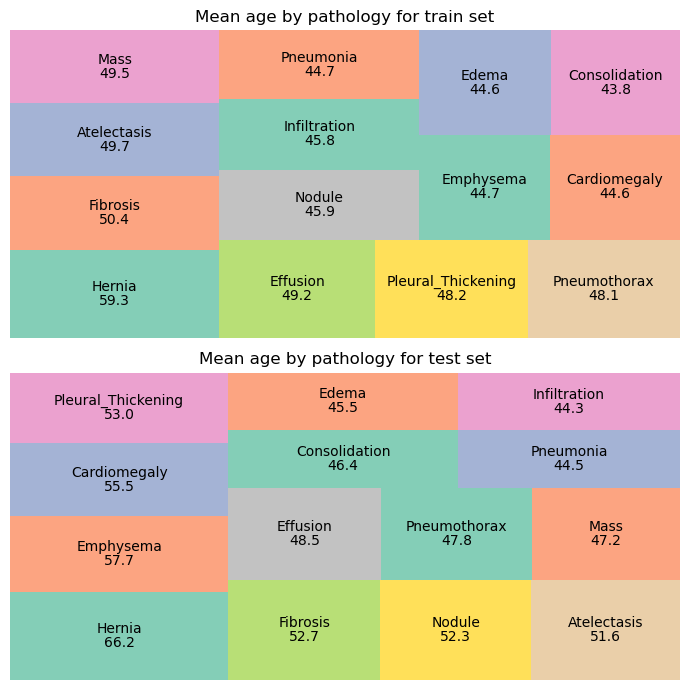

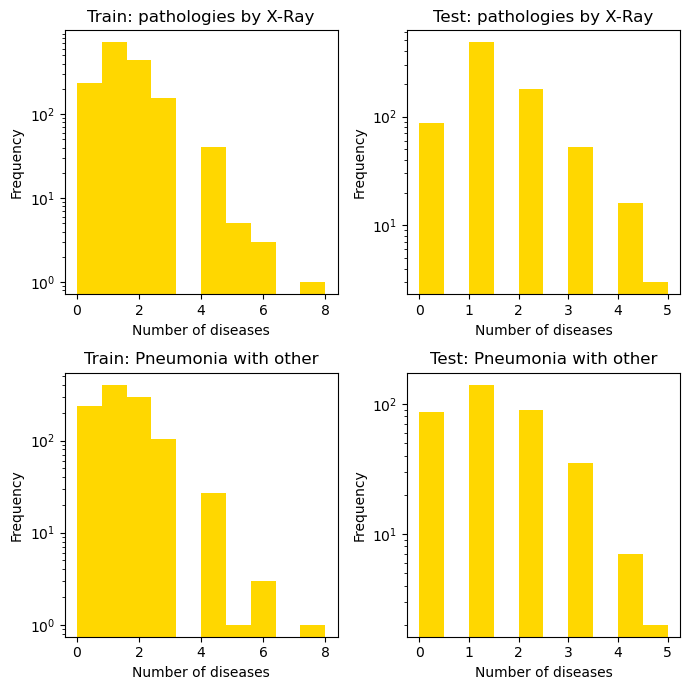

In [23]:
check_dataset_overall(train_data, val_data)

The visual inspection of the train and test datasets doesn't reveal any unbalance issue, except for position. That could be and issue, but the general Pneumonia population has more Anteroposterior images than Posteroanterior, as it was noted in the previous notebook. 
We will try to train a model despite this issue. 

### Checking train and test for Pneumonia population

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


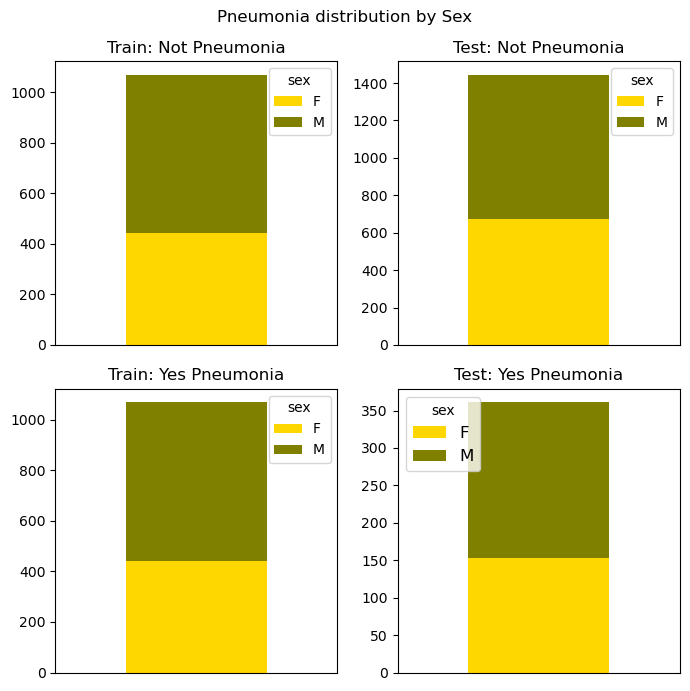

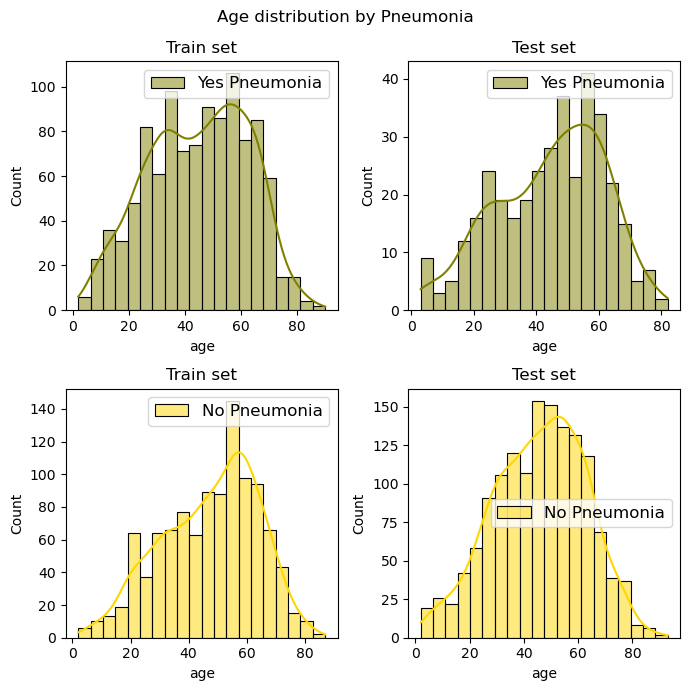

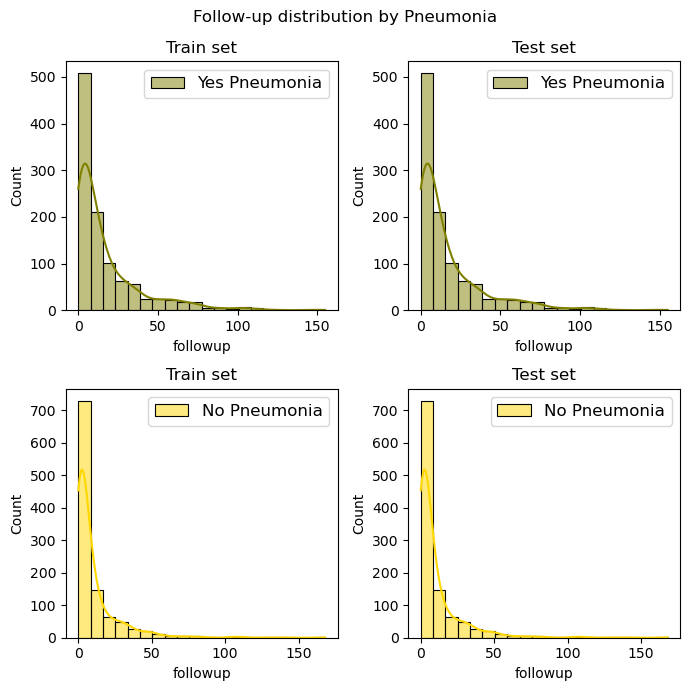

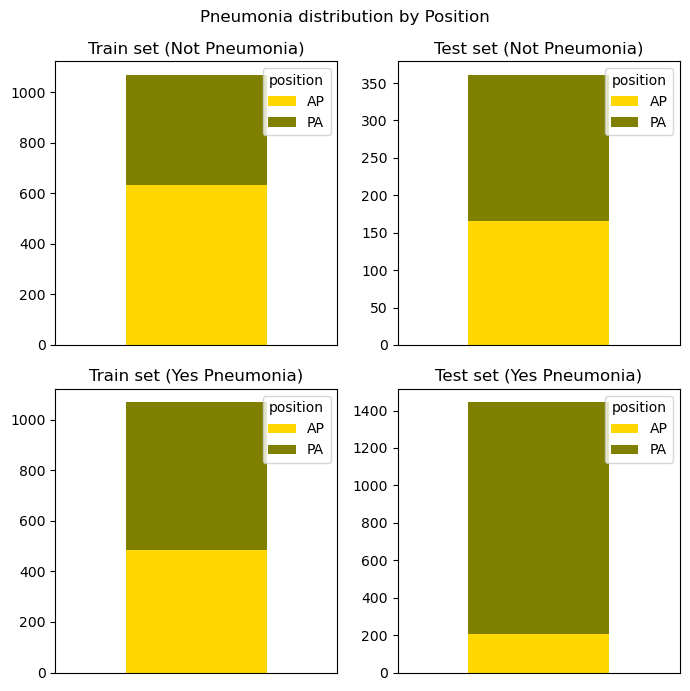

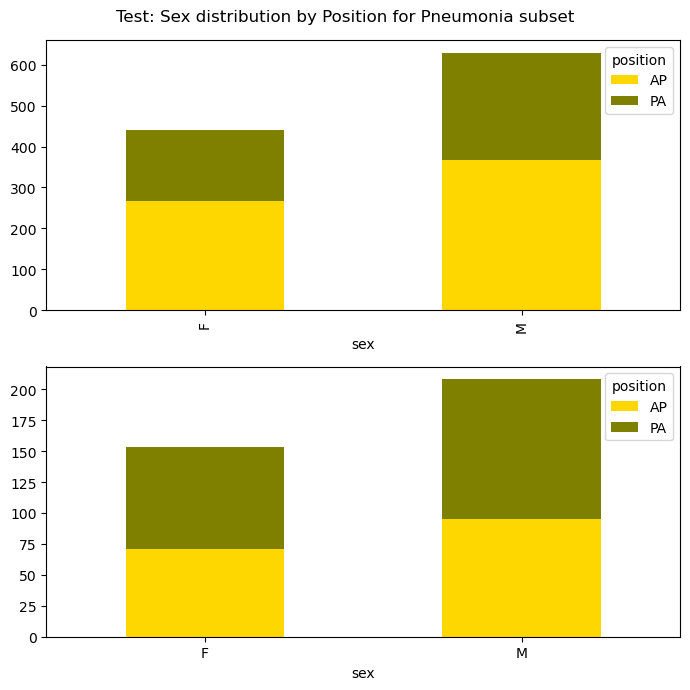

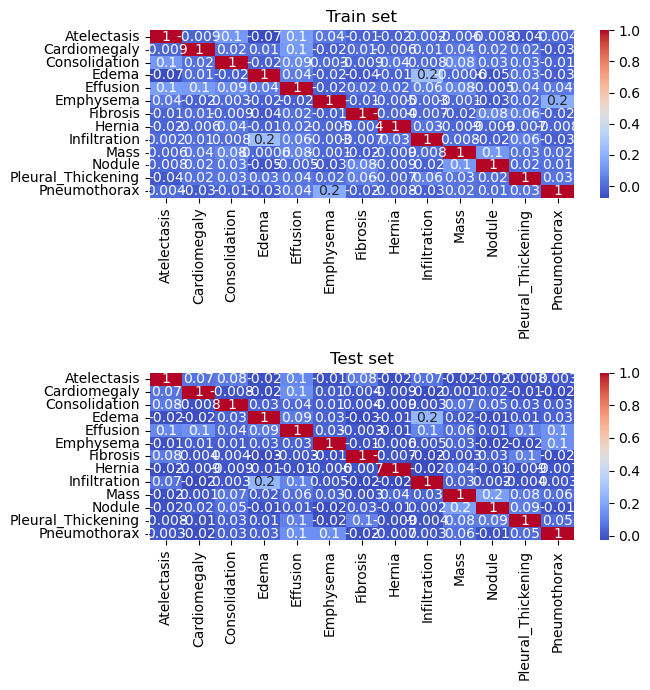

In [24]:
check_dataset_pneumonia(train_data, val_data)

Nothing to reveal, except that there are more anteroposterior xrays for pneumonia in the train set than in the test set. As train set is 50-50% and test set 80-20% in relation to pneumonia, this could happen. 

# Model training

An essential image transformation is to remove the borders of the image, to remove any digital annotation and arrows that usually comes in the xray and are placed in the peripheria. The only valuable data to diagnose pneumonia is the lung tissue, which usually looks black (radiolucid) in normal conditions and white (radiopacity) when lung tissue augments its density. That usually occurs because there is less proportion of air cause the lung tissue gets inflamated (which comes with more water, more proteins, more mucus) by something (could be virus, bacteria, tumor cells, autoinmune disease, strange object...any that inflamates the cells)

In [25]:
# Apply cropping to the images keeping only the center of the image
# This way we can remove the black borders and digital arrows / labels / wires / etc. 
# Pneumonia is only diagnosed in the lungs, so we can remove the rest of the image
# This is not the ideal approach (resize, crop, resize)
# But it is the only one that worked for transforming during training with GPU

def cropping(img):

    '''
    This function crops the image to the center of the image,
    resizes it to 224x224,
    and applies the preprocessing function for the pretrained model

    Returns the preprocessed image
    '''
    
    cropping_layer = CenterCrop(180,180)
    
    if pretrained == 'vgg16':
        preprocessor = vgg16_preprocess_input
    if pretrained == 'resnet':
        preprocessor = resnet_preprocess_input

    img = np.expand_dims(img, axis=0)

    img = cropping_layer(img)

    img = Resizing(224,224, interpolation='nearest',crop_to_aspect_ratio=True)(img)

    img = preprocessor(img)
    
    return img

def my_image_augmentation():
    '''
    This function creates the ImageDataGenerator object for the training set
    '''
    train_idg = ImageDataGenerator(samplewise_center = True,
                            horizontal_flip = True, 
                            vertical_flip = False, 
                            height_shift_range = 0.2, 
                            width_shift_range = 0.2, 
                            rotation_range = 15, 
                            shear_range = 0.1,
                            zoom_range= 0.2,
                            preprocessing_function = lambda x: cropping(x),
                            rescale=None
                        )
    return train_idg

def my_image_augmentation_val():
    '''
    This function creates the ImageDataGenerator object for the validation set
    '''
    val_idg = ImageDataGenerator(
                            preprocessing_function = lambda x: cropping(x),
                            rescale=None
                        )
    return val_idg


def make_train_gen(df, idg, img_size, feature):
    '''
    This function creates the training generator
    '''
    
    train_gen = idg.flow_from_dataframe(dataframe=df, 
                                            directory=path_for_generator, 
                                            x_col = column_images,
                                            y_col = feature,
                                            seed = seed,
                                            class_mode = 'binary',
                                            target_size = img_size,
                                            
                                            batch_size = batch_n,
                                            crop_to_aspect_ratio = True,
                                            interpolation='nearest',
                                            shuffle = True
                                            )
    return train_gen



def make_val_gen(df, idg, img_size, feature):
    '''
    This function creates the validation generator
    '''
    val_gen = idg.flow_from_dataframe(dataframe=df, 
                                            directory=path_for_generator, 
                                            x_col = column_images,
                                            y_col = feature,
                                            class_mode = 'binary',
                                            seed = seed,
                                            target_size = img_size,
                                            
                                            batch_size = batch_n,
                                            crop_to_aspect_ratio = True,
                                            interpolation='nearest', 
                                            shuffle = False)                            
    return val_gen

In [26]:
train_idg = my_image_augmentation()
train_gen = make_train_gen(train_data, train_idg, img_size, feature_to_classify)

val_idg = my_image_augmentation_val()
val_gen = make_val_gen(val_data, val_idg, img_size, feature_to_classify)

## Check the generator
valX, valY = val_gen.next()

Found 2138 validated image filenames belonging to 2 classes.
Found 1805 validated image filenames belonging to 2 classes.
Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-02-06 16:22:02.687851: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-06 16:22:02.689727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Augmentation images for training set examples

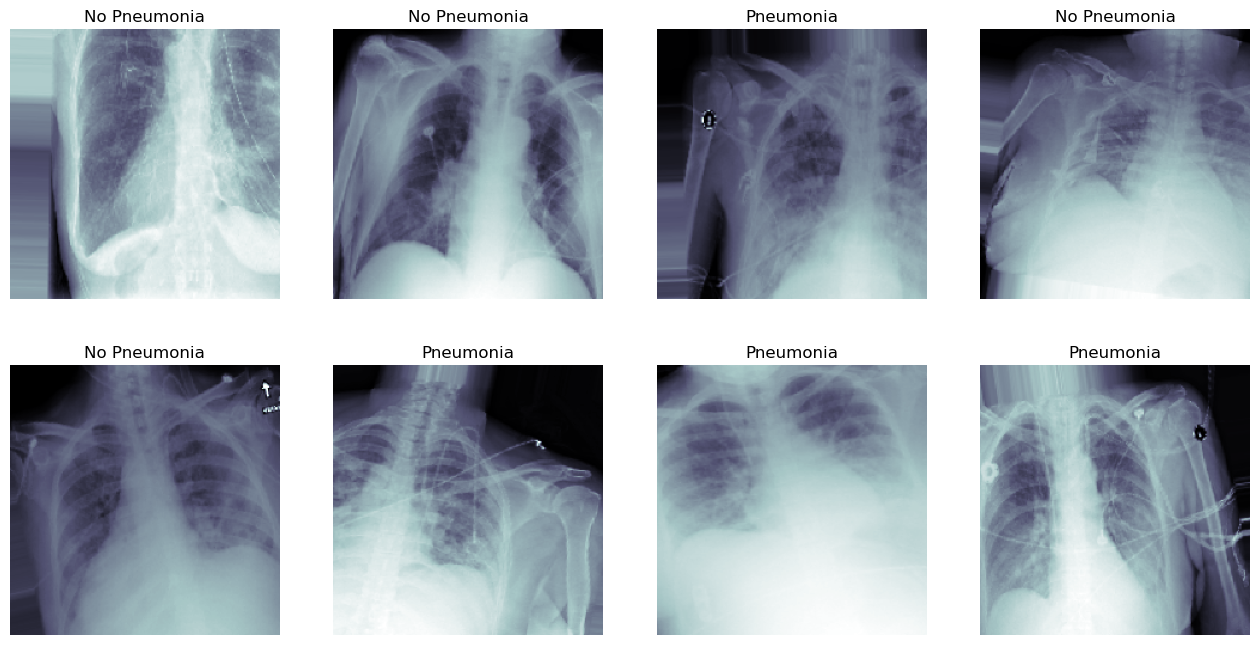

In [27]:
## Check the generator output plotting some image examples for the training set with augmentation
train_gen.reset()
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1.0:
        c_ax.set_title(f'{feature_to_classify}')
    else:
        c_ax.set_title(f'No {feature_to_classify}')
    c_ax.axis('off')

### Preprocessed images for validation set examples

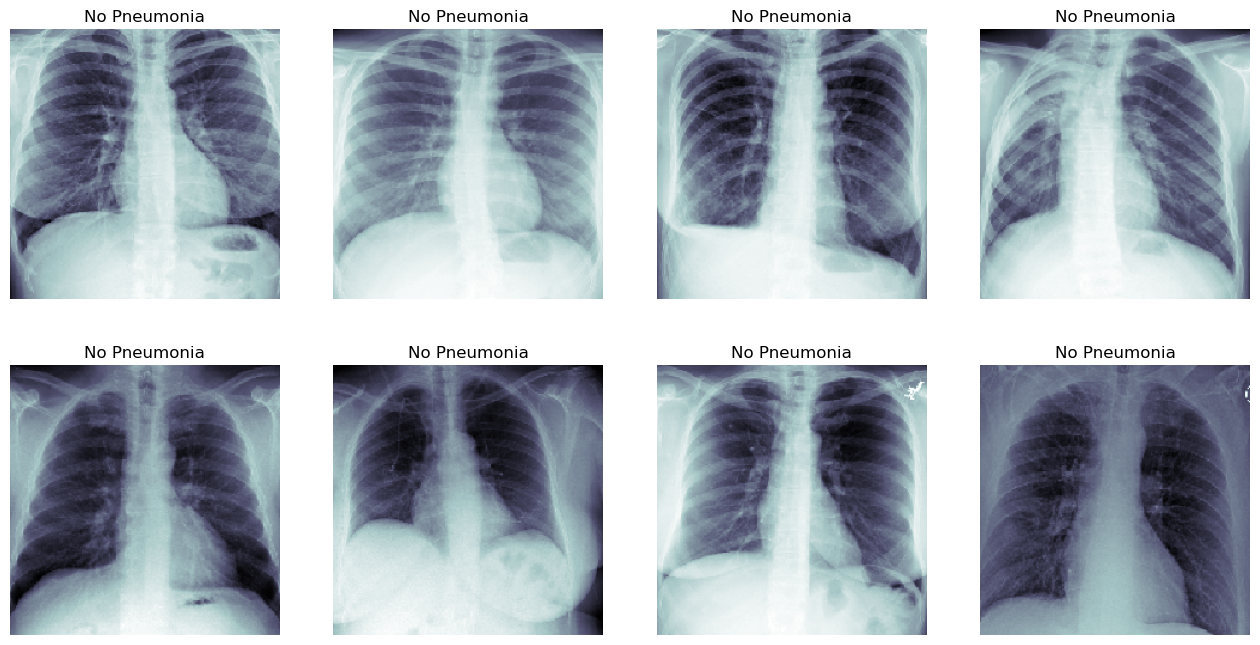

In [28]:
## Check the generator output plotting some image examples for the training set with augmentation
val_gen.reset()
t_x, t_y = next(val_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1.0:
        c_ax.set_title(f'{feature_to_classify}')
    else:
        c_ax.set_title(f'No {feature_to_classify}')
    c_ax.axis('off')

### Model function builders

In [320]:
def load_pretrained_model():
    '''
    This function loads the pretrained model and returns the model
    Depending on the pretrained model for transfer learning, it will return the model RESTNET or VGG16
    It also freezes the layers that are not going to be trained
    Which for VGG16 it is the first 4 convolutional blocks
    '''
    
    if pretrained == 'vgg16':

        model = VGG16(include_top=True, weights='imagenet')
        transfer_layer = model.get_layer(layer_vgg16_of_interest)
        vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

        ### Freeze all layers except the last 4
        first_trainable_layer = -4
        for layer in vgg_model.layers[:first_trainable_layer]:
            layer.trainable = False
        list_of_layers = []
        for layer in vgg_model.layers[first_trainable_layer:]:
            list_of_layers.append(layer.name)
            layer.trainable = True
        print('List of trainable convolutional layers: {}'.format(list_of_layers))

        return vgg_model

    elif pretrained == 'resnet50':
        model = ResNet50(include_top=True, weights='imagenet')

        transfer_layer = model.get_layer('conv5_block3_out')

        ### Freeze all layers except the last 7
        first_trainable_layer = -7

        net_model = Model(inputs=model.input, outputs=transfer_layer.output)

        for layer in net_model.layers[:first_trainable_layer]:
            layer.trainable = False

        for layer in net_model.layers[first_trainable_layer:]:
            print(f'\t{layer.name}')
            layer.trainable = True
            
        return net_model

In [321]:
def build_my_model(cnn_model):
        '''
        This function builds the model that will be trained
        It takes as input the pretrained model
        It adds 3 convolutional layer with 512 filters of size 14x14
        It adds a batch normalization layer
        It adds a max pooling layer
        And then 3 fully connected layers
        '''
        my_model = Sequential()

        my_model.add(cnn_model)

        # Add a convolutional layer with 512 filters of size 14x14
        my_model.add(Conv2D(filters=512,
                        kernel_size=kernel_size,
                        input_shape=(14, 14, 1),
                        activation='relu'))
        # Add a convolutional layer with 512 filters of size 14x14
        my_model.add(Conv2D(filters=512,
                        kernel_size=kernel_size,
                        input_shape=(14, 14, 1),
                        activation='relu'))
        # Add a convolutional layer with 512 filters of size 14x14
        my_model.add(Conv2D(filters=512,
                        kernel_size=kernel_size,
                        input_shape=(14, 14, 1),
                        activation='relu', name = 'last_conv_layer'))

        my_model.add(BatchNormalization())


        my_model.add(GlobalAveragePooling2D())

        ## Add fully connected layers with dropout depending on the initial setting
        ## It receives to lists, one with the number of neurons and the other with the dropout
        for i in list(zip(dense_n, dropout)):
                my_model.add(Dense(i[0], activation='relu', kernel_initializer='he_normal'))
                my_model.add(Dropout(i[1]))

        ## Add the output layer
        my_model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
        
        ## Compile the model
        metrics_all = ['accuracy',
                tf.keras.metrics.Precision(thresholds=0.5,name='precision'), 
                tf.keras.metrics.Recall(thresholds=0.5,name='recall'),
                tf.keras.metrics.AUC(name='auc')
                ]

        optimizer = Adam(learning_rate=learning_rate)
        loss = 'binary_crossentropy'

        my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics_all)
        
        return my_model

### Callbacks settings

In [323]:
weight_path="./models/{}_{}my_model.best.hdf5".format(version, filename_prefix)

if save_all_epochs == True:
    weight_path = weight_path[:-5] + "_{epoch:02d}_{val_loss}_improvement.hdf5"


checkpoint = ModelCheckpoint(weight_path, 
                            monitor= 'val_loss', 
                            verbose=1, 
                            save_best_only=False, 
                            mode= 'auto', 
                            save_weights_only = False)


## Since Apple runs only up to TF 2.9 we neeed the CustomStopper to be able to start the patience after a certain epoch
class CustomStopper(keras.callbacks.EarlyStopping):
    def __init__(self, monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', start_epoch = 100,restore_best_weights=True):
        super(CustomStopper, self).__init__(monitor=monitor,patience=patience,min_delta=min_delta,mode=mode,restore_best_weights=restore_best_weights)
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

early = CustomStopper(monitor= 'val_loss',
                    mode= 'auto',
                    patience=patience,
                    restore_best_weights=False, 
                    start_epoch = start_patience, 
                    verbose=1)

                    
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 10, verbose=1,factor=0.5, min_lr=0.000001)


callbacks_list = [checkpoint, early, learning_rate_reduction]

### Model summary

In [324]:
train_gen.reset()
cnn_model = load_pretrained_model()
my_model= build_my_model(cnn_model)
my_model.summary()

List of trainable convolutional layers: ['block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool']
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_47 (Functional)       (None, 14, 14, 512)       7635264   
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 512)       2359808   
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 512)       2359808   
                                                                 
 last_conv_layer (Conv2D)    (None, 8, 8, 512)         2359808   
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                                 
                                                                 
 global_average_

### Training the model
All the parameters can be checked on the second cell

In [325]:
history = my_model.fit(train_gen, 
                        validation_data = (valX, valY), 
                        epochs = epochs,
                        callbacks = callbacks_list, verbose=1,
                        shuffle = True)

Epoch 1/200


2023-02-05 17:56:35.732768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.8089 - accuracy: 0.4775 - precision: 0.4776 - recall: 0.4780 - auc: 0.4771

2023-02-05 17:58:06.136558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to ./models/v11_xray_udacitymy_model.best_01_0.6353034973144531_improvement.hdf5
67/67 [==============================] - 91s 1s/step - loss: 0.8089 - accuracy: 0.4775 - precision: 0.4776 - recall: 0.4780 - auc: 0.4771 - val_loss: 0.6353 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - lr: 0.0010
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.4986 - precision: 0.4987 - recall: 0.5323 - auc: 0.5004
Epoch 2: saving model to ./models/v11_xray_udacitymy_model.best_02_11.079977989196777_improvement.hdf5
67/67 [==============================] - 89s 1s/step - loss: 0.7158 - accuracy: 0.4986 - precision: 0.4987 - recall: 0.5323 - auc: 0.5004 - val_loss: 11.0800 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - lr: 0.0010
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.7044 - accuracy: 0.5374 - precision

### Model perfomance

Making predictions, looking for optimal threshold and making a confussion matrix. 

In [326]:
val_gen.reset()
pred_Y = my_model.predict(val_gen, verbose = True)

2023-02-05 20:00:44.732772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - 49s 869ms/step


### Functions for plotting perfomance metrics

In [327]:
# function to plot the roc_curve. 
def plot_roc_curve(ground_truth, probability):
    auc = roc_auc_score(ground_truth, probability)
    print('AUC: %.3f' % auc)

    fpr, tpr, thresholds = roc_curve(ground_truth, probability)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(fpr, tpr, label='AUC = %0.2f' % auc)
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

# function to plot the precision_recall_curve. 
def plot_precision_recall_curve(ground_truth, probability):
    precision, recall, thresholds = precision_recall_curve(ground_truth, probability)

    # plot the precision-recall curve
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.legend(loc='lower left')
    plt.xlim([0, 1])
    plt.ylim([0, 0.7])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()
    
# function to plot the history.
def plot_history(history):
    # Plotting the loss
    plt.figure(figsize=(8, 5))
    #plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.show()

# function to plot the accuracy.
def plot_accuracy(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['accuracy', 'val_accuracy'])
    plt.show()

# function to plot the learning rate.
def plot_lr(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['lr'])
    plt.legend(['lr'])
    plt.show()


## Checking the threshold selected
def check_thres(thres, valY = val_gen.labels, pred_Y = pred_Y):

    performances = pd.DataFrame({'y_test': valY, 'probability': pred_Y.flatten()})
    performances['y_pred'] = np.where(performances[['probability']] >= thres, 1, 0)

    print("*" * 50)
    print('Threshold selected: {}'.format(thres))
    TN, FP, FN, TP = confusion_matrix(performances['y_test'], performances['y_pred']).ravel()

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    especificity = TN / (TN + FP)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print("Recall: {:.2f}".format(recall))
    print("Precision: {:.2f}".format(precision))
    print("Especificity: {:.2f}".format(especificity))
    print("Accuracy: {:.2f}".format(accuracy))
    print("F1 Score: {:.2f}".format(f1_score))
    print("*" * 50)

    print(classification_report(performances['y_test'], performances['y_pred']))
    print("*" * 50)
    print("")
    matrix = confusion_matrix(performances['y_test'], performances['y_pred'])
    fig, ax = plt.subplots(figsize=(5, 3))
    ConfusionMatrixDisplay(matrix).plot(ax=ax)
    plt.show()


## Search for the best threshold to use for your model
## Not used in this notebook
def search_thres(min, max, valY = val_gen.labels, pred_Y = pred_Y):

    all_thres = list(np.arange(min, max+0.1, 0.1))
    all_thres_col = ['thres_' + str(i) for i in all_thres]
    all_thres_names = ['Threshold ' + str(i) for i in all_thres]

    performances = pd.DataFrame({'ground_truth': valY, 'probability': pred_Y.flatten()})

    for i in zip(all_thres, all_thres_col):
        performances[i[1]] = np.where(performances[['probability']] >= i[0], 1, 0)

    for i, thres in enumerate(all_thres_col):
        print("*" * 50)
        print(all_thres_names[i],':')
        TN, FP, FN, TP = confusion_matrix(performances['ground_truth'], performances[thres]).ravel()

        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        especificity = TN / (TN + FP)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall)
        
        print("Recall: {:.2f}".format(recall))
        print("Precision: {:.2f}".format(precision))
        print("Especificity: {:.2f}".format(especificity))
        print("Accuracy: {:.2f}".format(accuracy))
        print("F1 Score: {:.2f}".format(f1_score))
        print("*" * 50)

        #print(classification_report(performances['ground_truth'], performances[thres]))
        matrix = confusion_matrix(performances['ground_truth'], performances[thres])
        fig, ax = plt.subplots(figsize=(5, 3))
        ConfusionMatrixDisplay(matrix).plot(ax=ax)
        plt.show()

def get_classes(pred, thres):
        classes = pred.copy()
        classes[classes>=thres] = 1
        classes[classes<thres] = 0
        return classes

## Plotting the F1 score for different thresholds to find the best one
def plot_f1_thres(steps):
    thresh_vals = np.arange(0, 1, steps)
    f1_vals = []
    for i in thresh_vals:
        f1_vals += [
            f1_score(
                y_true=val_gen.labels,
                y_pred=get_classes(pred_Y, i),
                pos_label=1,
                average='binary',
                sample_weight=None
            )
        ]
    f1_vals = np.array(f1_vals)


    print(f"Max F1 score: {f1_vals.max():.3f}, threshold: {thresh_vals[np.argmax(f1_vals)]:.3f}")
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(thresh_vals, f1_vals)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1 score')
    ax.set_ylim(0, f1_vals.max() * 1.2)
    ax.legend(['F1 score'])
    plt.show()
    

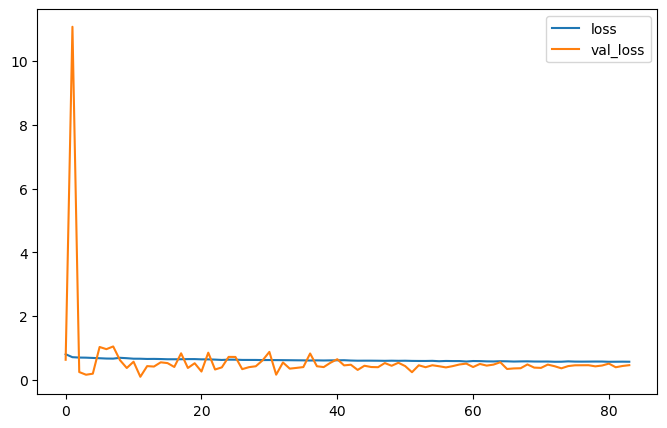

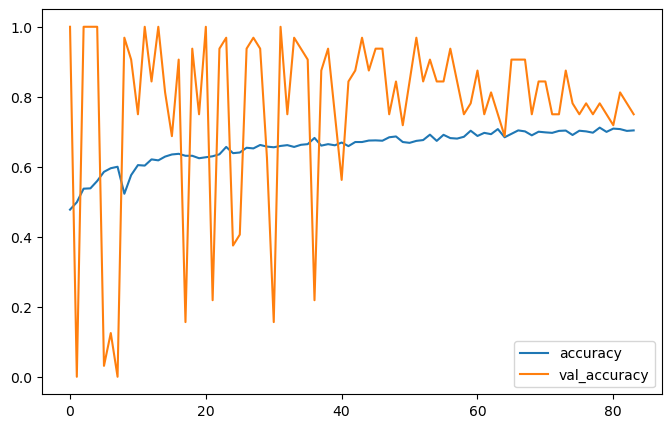

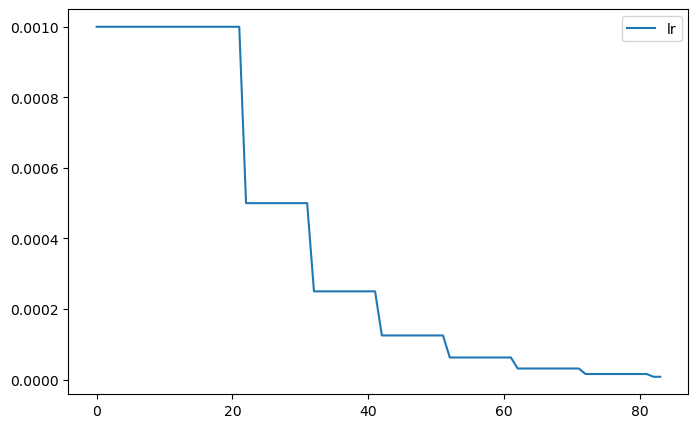

AUC: 0.762


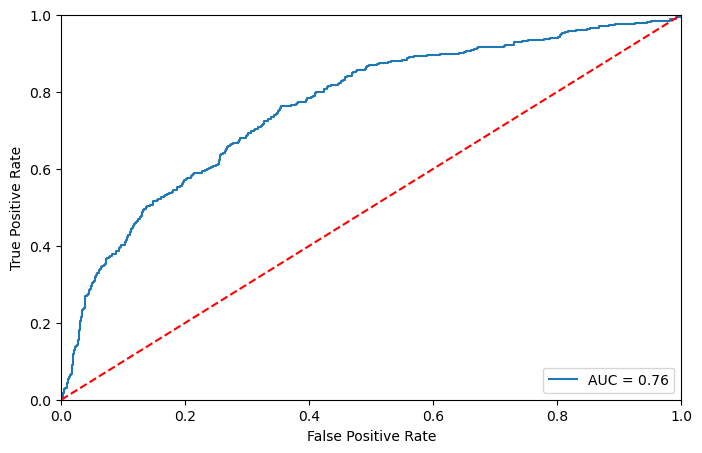

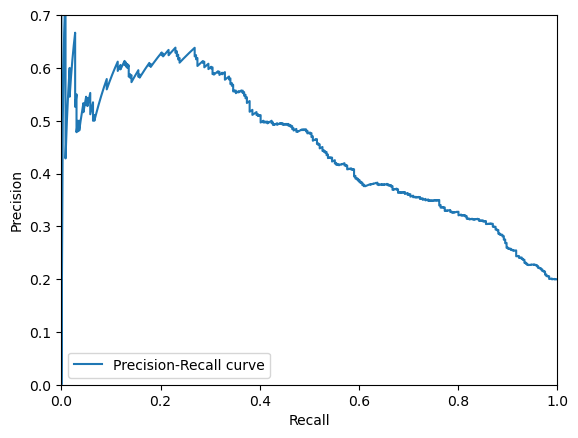

Max F1 score: 0.490, threshold: 0.634


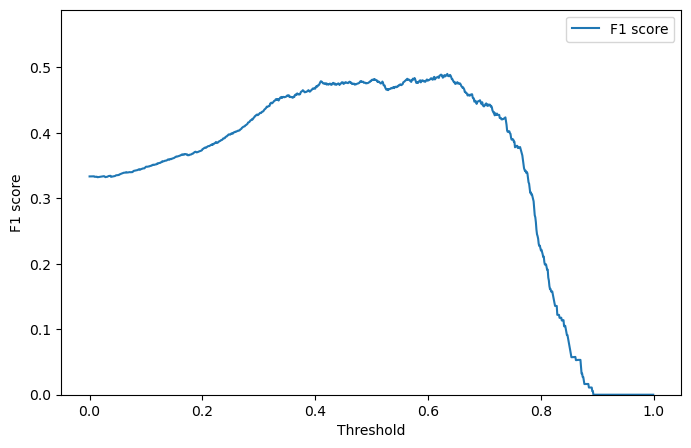

In [328]:
## Plotting figures
plot_history(history)
plot_accuracy(history)
plot_lr(history)
plot_roc_curve(val_gen.labels, pred_Y)
plot_precision_recall_curve(val_gen.labels, pred_Y)
plot_f1_thres(steps = 0.001)

## Confussion matrix and final metrics for selected threshold

**************************************************
Threshold selected: 0.634
Recall: 0.50
Precision: 0.48
Especificity: 0.86
Accuracy: 0.79
F1 Score: 0.49
**************************************************
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1444
           1       0.48      0.50      0.49       361

    accuracy                           0.79      1805
   macro avg       0.68      0.68      0.68      1805
weighted avg       0.79      0.79      0.79      1805

**************************************************



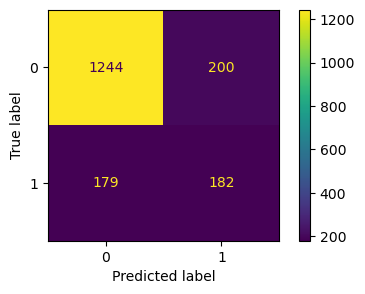

In [339]:
### Checking the threshold selected with the best F1 score
check_thres(0.634)

## Examples of predictions

Check the GradCAM activation map for detailed information.

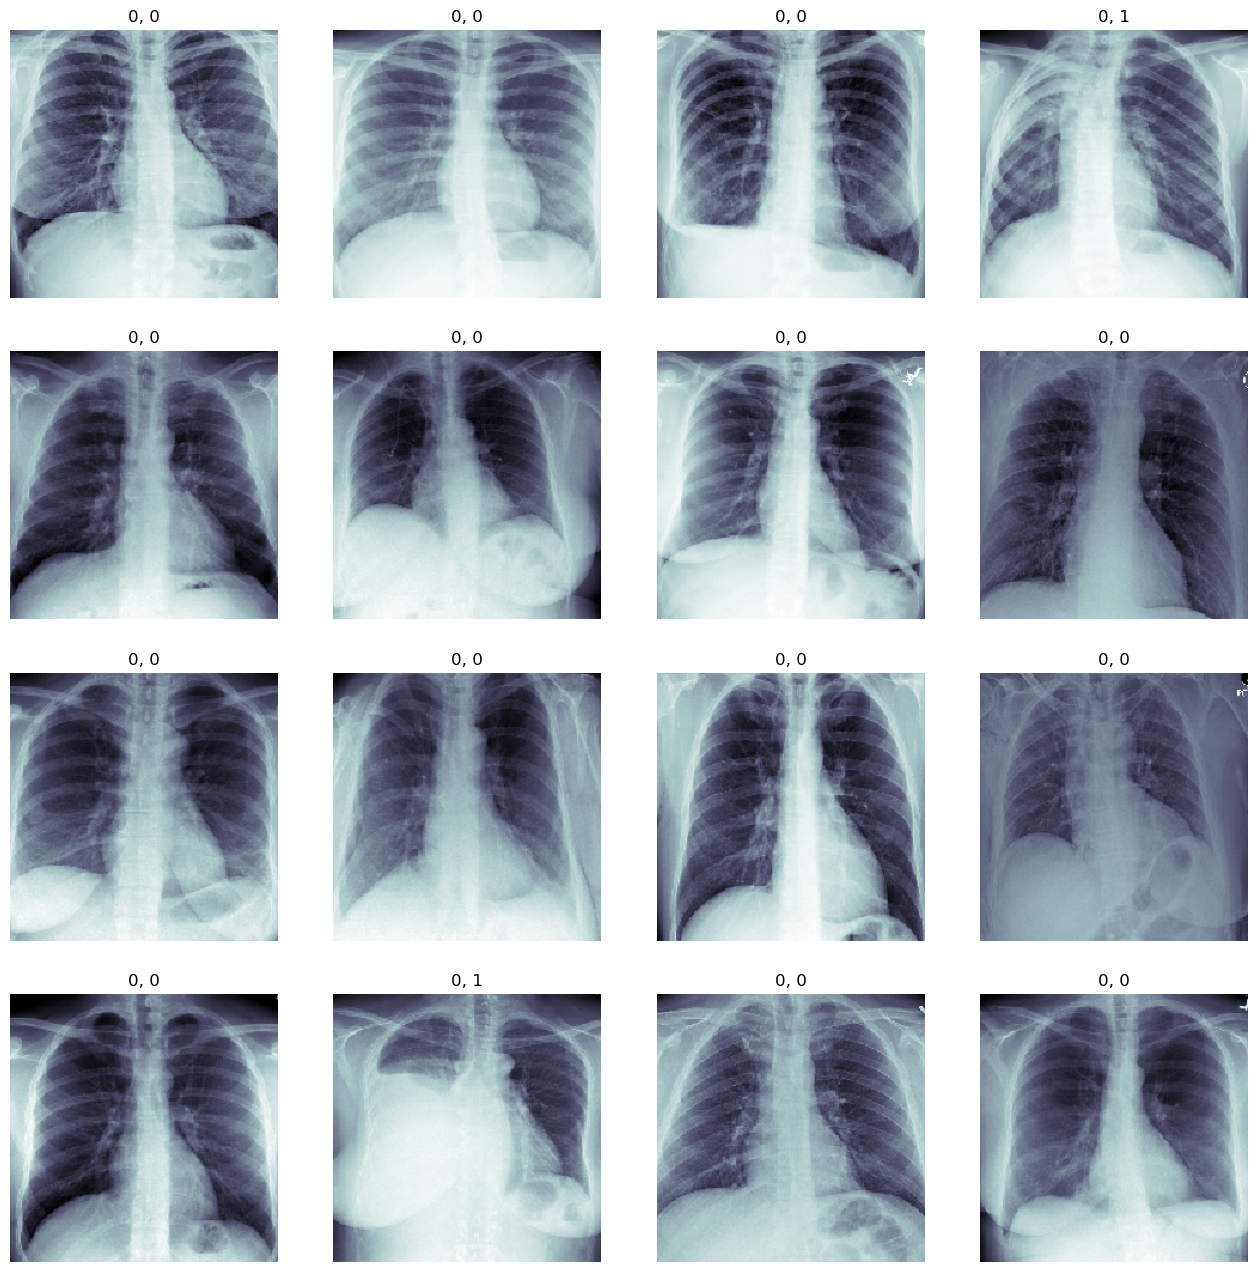

In [330]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.6:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.6: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

### Saving the model arquitecture and weights

In [331]:
## Just save model architecture to a .json:
model_json = my_model.to_json()
with open(f"./models/{version}_my_model_{filename_prefix}_{feature_to_classify}.json", "w") as json_file:
    json_file.write(model_json)

In [332]:
## Save model weights to a .h5:
my_model.save(f"./models/{version}_my_model_{filename_prefix}_{feature_to_classify}_final.h5")

## Grad-CAM class activation visualization

Original code from [Keras official website](https://keras.io/examples/vision/grad_cam/).

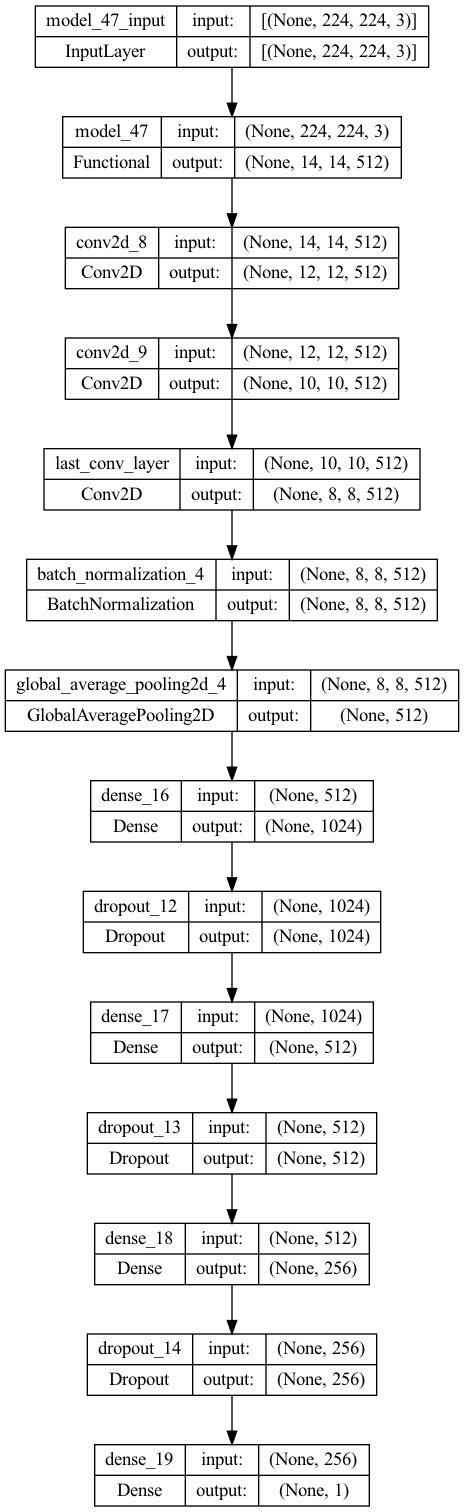

In [340]:
import tensorflow as tf
show_model = tf.keras.models.load_model(f"./models/{version}_my_model_{filename_prefix}_{feature_to_classify}_final.h5")
tf.keras.utils.plot_model(show_model, show_shapes=True)

In [341]:
show_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_47 (Functional)       (None, 14, 14, 512)       7635264   
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 512)       2359808   
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 512)       2359808   
                                                                 
 last_conv_layer (Conv2D)    (None, 8, 8, 512)         2359808   
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                             

In [482]:
def cropping(img):
    '''
    This function crops the image to the center and resizes it to 224x224
    '''
    
    cropping_layer = CenterCrop(800,800)
    
    if pretrained == 'vgg16':
        preprocessor = vgg16_preprocess_input
    if pretrained == 'resnet':
        preprocessor = resnet_preprocess_input

    img = np.expand_dims(img, axis=0)

    img = cropping_layer(img)

    img_cropped = Resizing(224,224, interpolation='nearest',crop_to_aspect_ratio=True)(img)

    img = preprocessor(img_cropped)

    return img, img_cropped


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    '''
    This function creates a heatmap with the GradCAM algorithm
    '''
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    '''
    This function creates the superimposed image
    '''

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

def get_new_map(img_size, layer_conv_layer = 'last_conv_layer', model = show_model):
    '''
    This function plots the original image, 
    the cropped image with preprocessing,
    the heatmap and the superimposed image
    '''

    mask = df[feature_to_classify] == 'Yes'
    pneumonia_df_tiny = df[mask].sample(100, random_state=seed)

    # The local path to our target image
    img_path = pneumonia_df_tiny.path.sample(1).to_string(index=False)

    # `img` is a PIL image of size 224x224
    img_original = tf.keras.preprocessing.image.load_img(img_path)

    # `array` is a float32 Numpy array of shape (224, 224, 3)
    img = tf.keras.preprocessing.image.img_to_array(img_original)

    # We crop and resize the image to 224x224 and add a dimension to transform our array into a "batch"
    img_preprocessed, img_cropped = cropping(img)

    ### PREDICTIONS
    # Remove layers up to the last conv layer selected
    index = 0
    for i,s in enumerate(show_model.layers[::-1]):
        if layer_conv_layer in s.name:
            index = -i-1
            for i in list(range(index,1,1)):
                show_model.layers[i].activation = None
            break

    # Print what the top predicted class is
    preds = show_model.predict(img_preprocessed)
    print("Predicted:", preds[0][0])

    ### PLOTTING GRADCAM
    ## Plotting all the images
    fig, ax = plt.subplots(2, 2, figsize=(8, 8))

    # Display original image
    ax[0,0].imshow(img_original)
    ax[0,0].set_title('Original image')
    ax[0,0].axis('off')

    # Display preprocessed image
    ax[0,1].imshow((img_preprocessed[0].numpy()*255).astype(np.uint8))
    ax[0,1].set_title('Cropped and preprocess image')
    ax[0,1].axis('off')

    # Display heatmap
    heatmap = make_gradcam_heatmap(img_preprocessed, model, layer_conv_layer, pred_index=None)
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title('Heatmap')

    # We the final image
    superimposed_img = display_gradcam(img_preprocessed[0], heatmap)
    ax[1,1].imshow(superimposed_img)
    ax[1,1].set_title('Superimposed image')
    ax[1,1].axis('off')

    plt.tight_layout()
    plt.show()


### Heatmap activation for random validation images

1/1 [==============================] - 0s 29ms/step
Predicted: 231778130.0


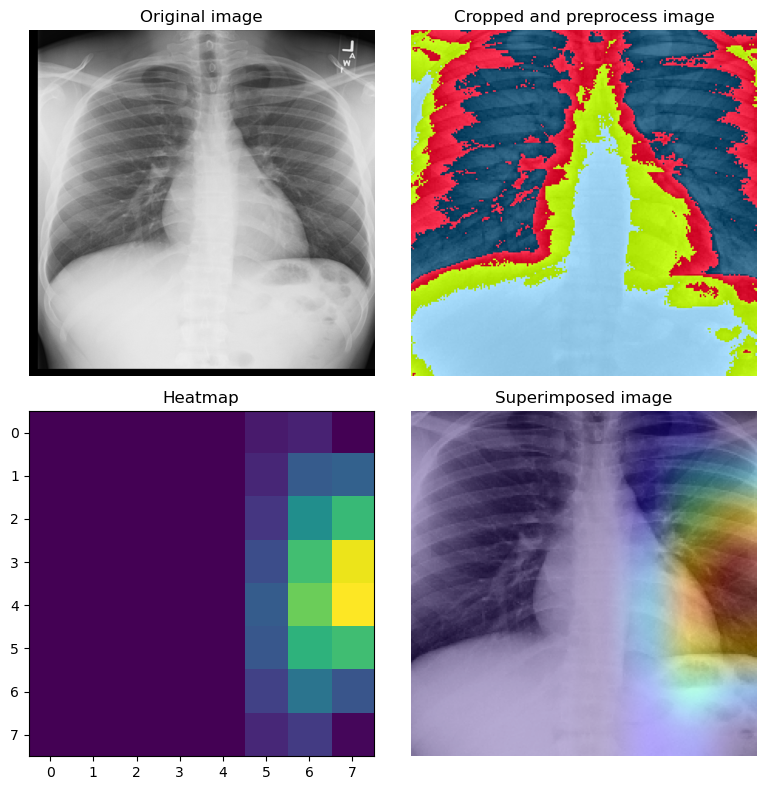

1/1 [==============================] - 0s 14ms/step
Predicted: 31269688.0


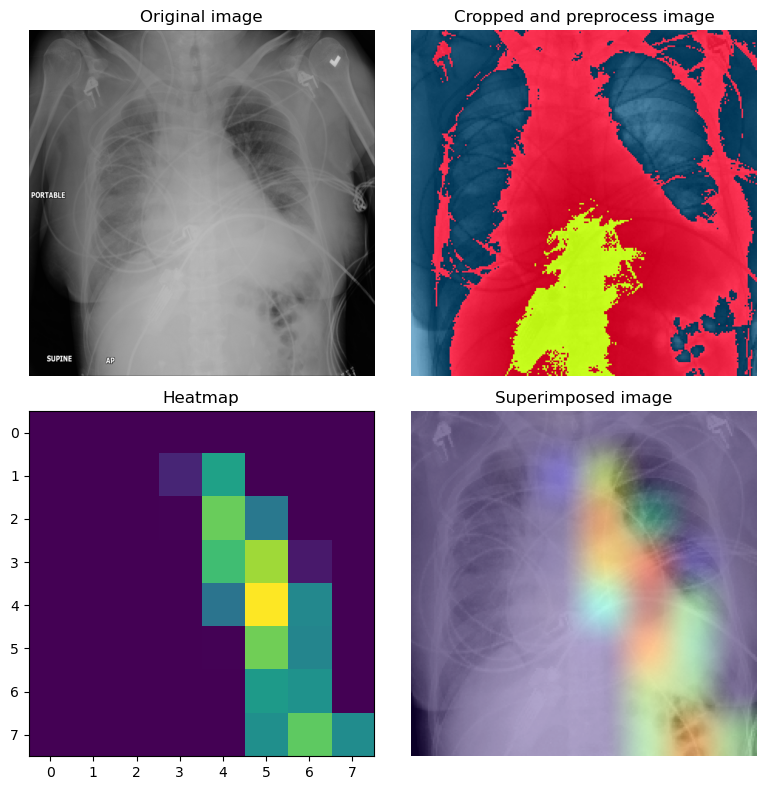

1/1 [==============================] - 0s 22ms/step
Predicted: 179650460.0


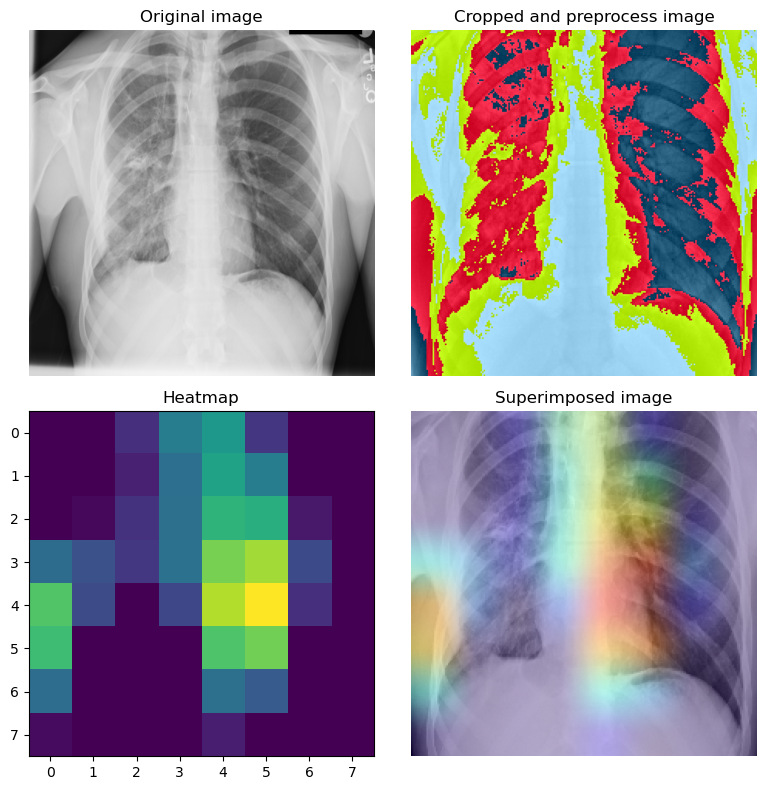

1/1 [==============================] - 0s 10ms/step
Predicted: 77448960.0


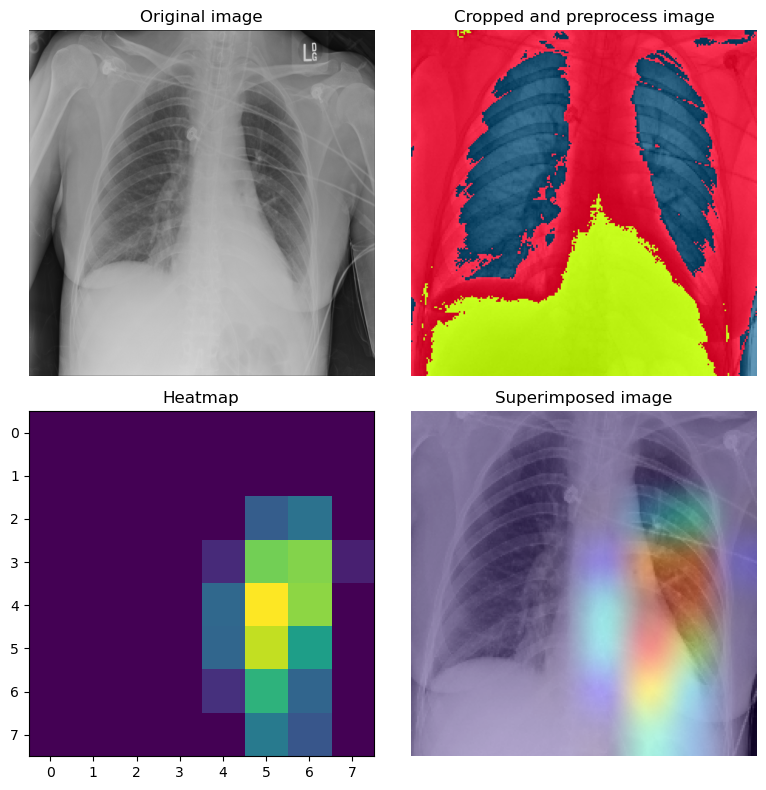

1/1 [==============================] - 0s 11ms/step
Predicted: 64149972.0


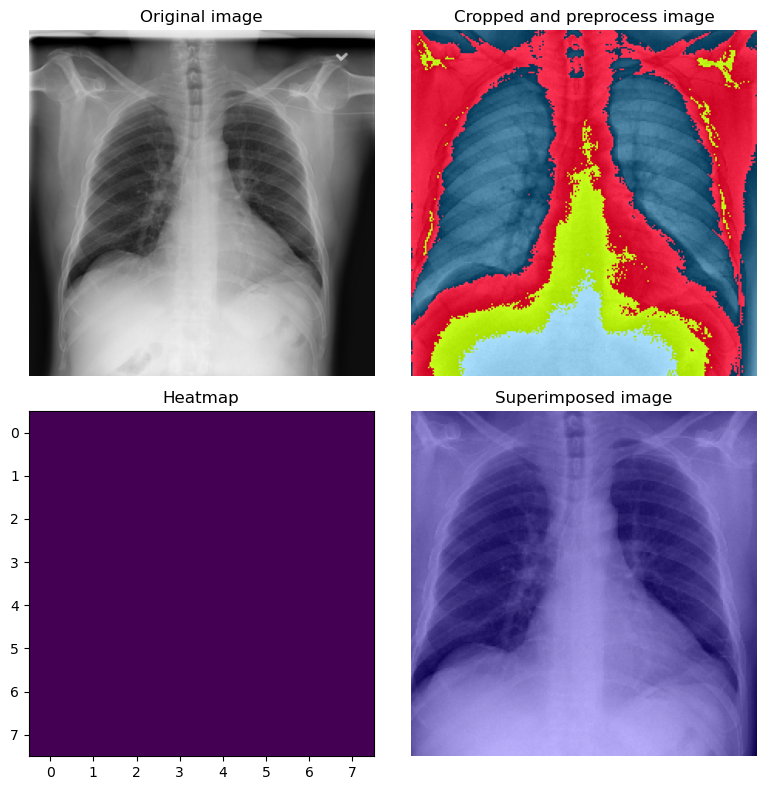

In [484]:
## GET A GRADMAP for 5 random images
# CONVOLUTIONAL LAYERS to pick: 'conv2d_8' 'conv2d_9' 'last_conv_layer'
for i in range(5):
    get_new_map(img_size = img_size, layer_conv_layer = 'last_conv_layer', model = show_model)